In [2]:
#!pip install scikit-image

In [39]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature
from skimage.color import rgb2gray
import skimage

(4032, 3024, 3)


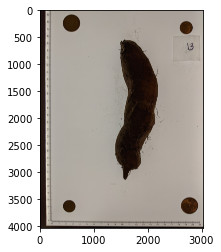

In [354]:
flist = os.listdir('Photos')
image = mpimg.imread(f'Photos/PXL_20201223_180745440.jpg')
imgplot = plt.imshow(image)
print (image.shape)

(4032, 3024)


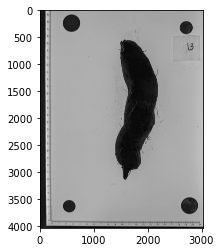

In [355]:
grayscale = rgb2gray (image)
imgplot = plt.imshow(grayscale, cmap=plt.cm.gray)
print (grayscale.shape)

## Intensity-based thresholding and segmentation

In [315]:
from skimage import data
from skimage.exposure import histogram
from skimage import morphology
from skimage.restoration import denoise_nl_means
import scipy.ndimage as ndi

In [356]:
hist, hist_centers = histogram(grayscale)
'''
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(grayscale, cmap=plt.cm.gray)
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')
'''

"\nfig, axes = plt.subplots(1, 2, figsize=(8, 3))\naxes[0].imshow(grayscale, cmap=plt.cm.gray)\naxes[0].axis('off')\naxes[1].plot(hist_centers, hist, lw=2)\naxes[1].set_title('histogram of gray values')\n"

In [357]:
def getLargestCC(segmentlabel):    
    assert( segmentlabel.max() != 0 ) # assume at least 1 CC
    largestCC = segmentlabel == np.argmax(np.bincount(segmentlabel.flat)[1:])+1
    return largestCC

In [358]:
fillh = ndi.binary_fill_holes(grayscale<0.5) #Intensity filtering
fillh2 = morphology.remove_small_objects(fillh, 100000) #Remove coins and tapes
fillh3 = morphology.binary_opening(fillh2,  morphology.disk(20)) #Remove root hair

In [359]:
fill_label = label(fillh3)
largest = getLargestCC(fill_label)
larlabel = label(largest)
larlabel

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [360]:
edtimage = ndi.distance_transform_edt(larlabel)
#pd.DataFrame(edtimage).to_csv('testOut.tab', sep="\t")
maxdist = 2 * np.amax(edtimage)
print (maxdist)

565.5616677251031


In [361]:
props = regionprops_table(larlabel,properties=('major_axis_length', 'minor_axis_length', 'bbox', 'filled_area', 
                                                'bbox_area','perimeter','extent'))
pd.DataFrame(props)

,major_axis_length,minor_axis_length,bbox-0,bbox-1,bbox-2,bbox-3,filled_area,bbox_area,perimeter,extent
0,2621.171321,699.094005,550,1383,3136,2179,1244328,2058456,6385.314426,0.604496


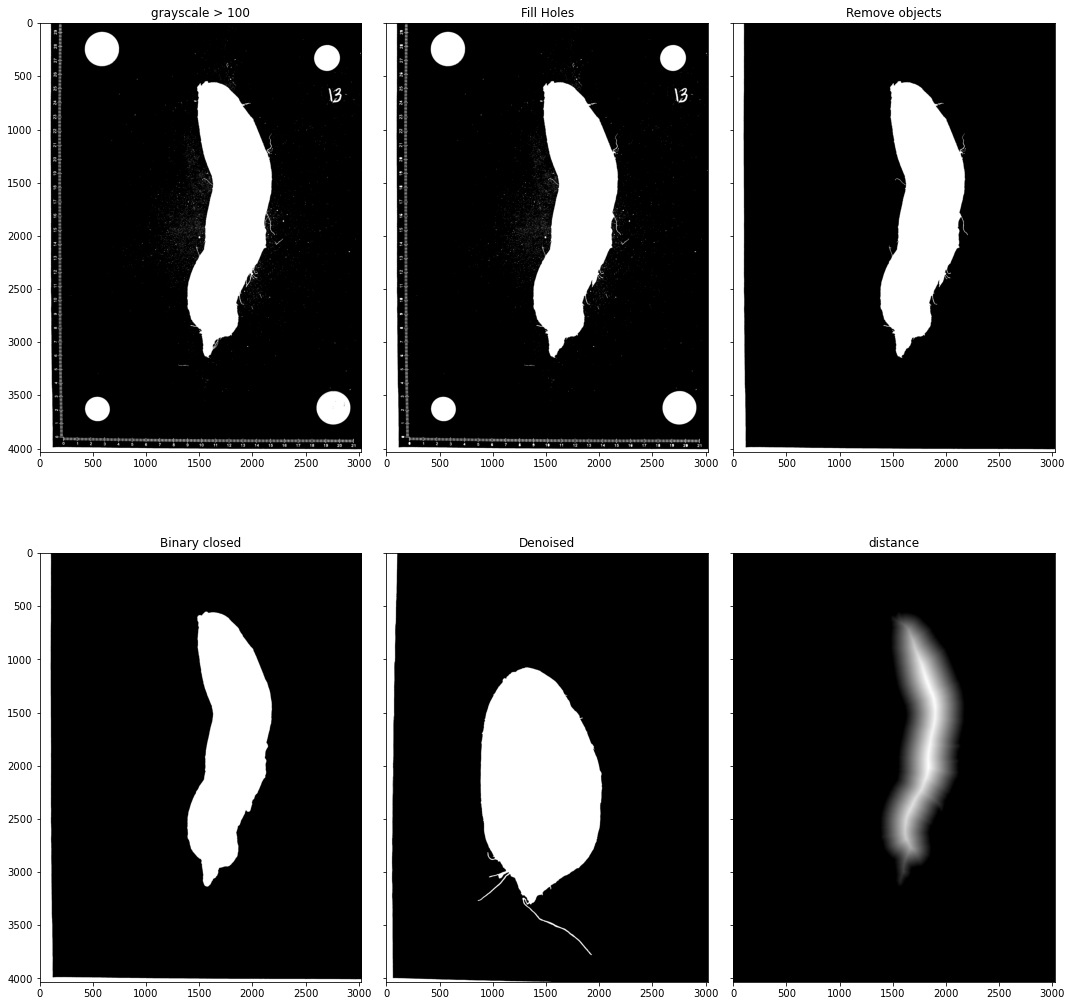

In [362]:

fig, axes = plt.subplots(2, 3, figsize=(15, 15), sharey=True)

axes[0,0].imshow(grayscale < 0.5, cmap=plt.cm.gray)
axes[0,0].set_title('grayscale > 100')

axes[0,1].imshow(fillh, cmap=plt.cm.gray)
axes[0,1].set_title('Fill Holes')

axes[0,2].imshow(fillh2, cmap=plt.cm.gray)
axes[0,2].set_title('Remove objects')

axes[1,0].imshow(fillh3, cmap=plt.cm.gray)
axes[1,0].set_title('Binary closed')

axes[1,1].imshow(fillh5, cmap=plt.cm.gray)
axes[1,1].set_title('Denoised')

axes[1,2].imshow(edtimage, cmap=plt.cm.gray)
axes[1,2].set_title('distance')



#for a in axes:
#    a.axis('off')

plt.tight_layout()


## Measure segmented region's properties

In [259]:
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
import plotly
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


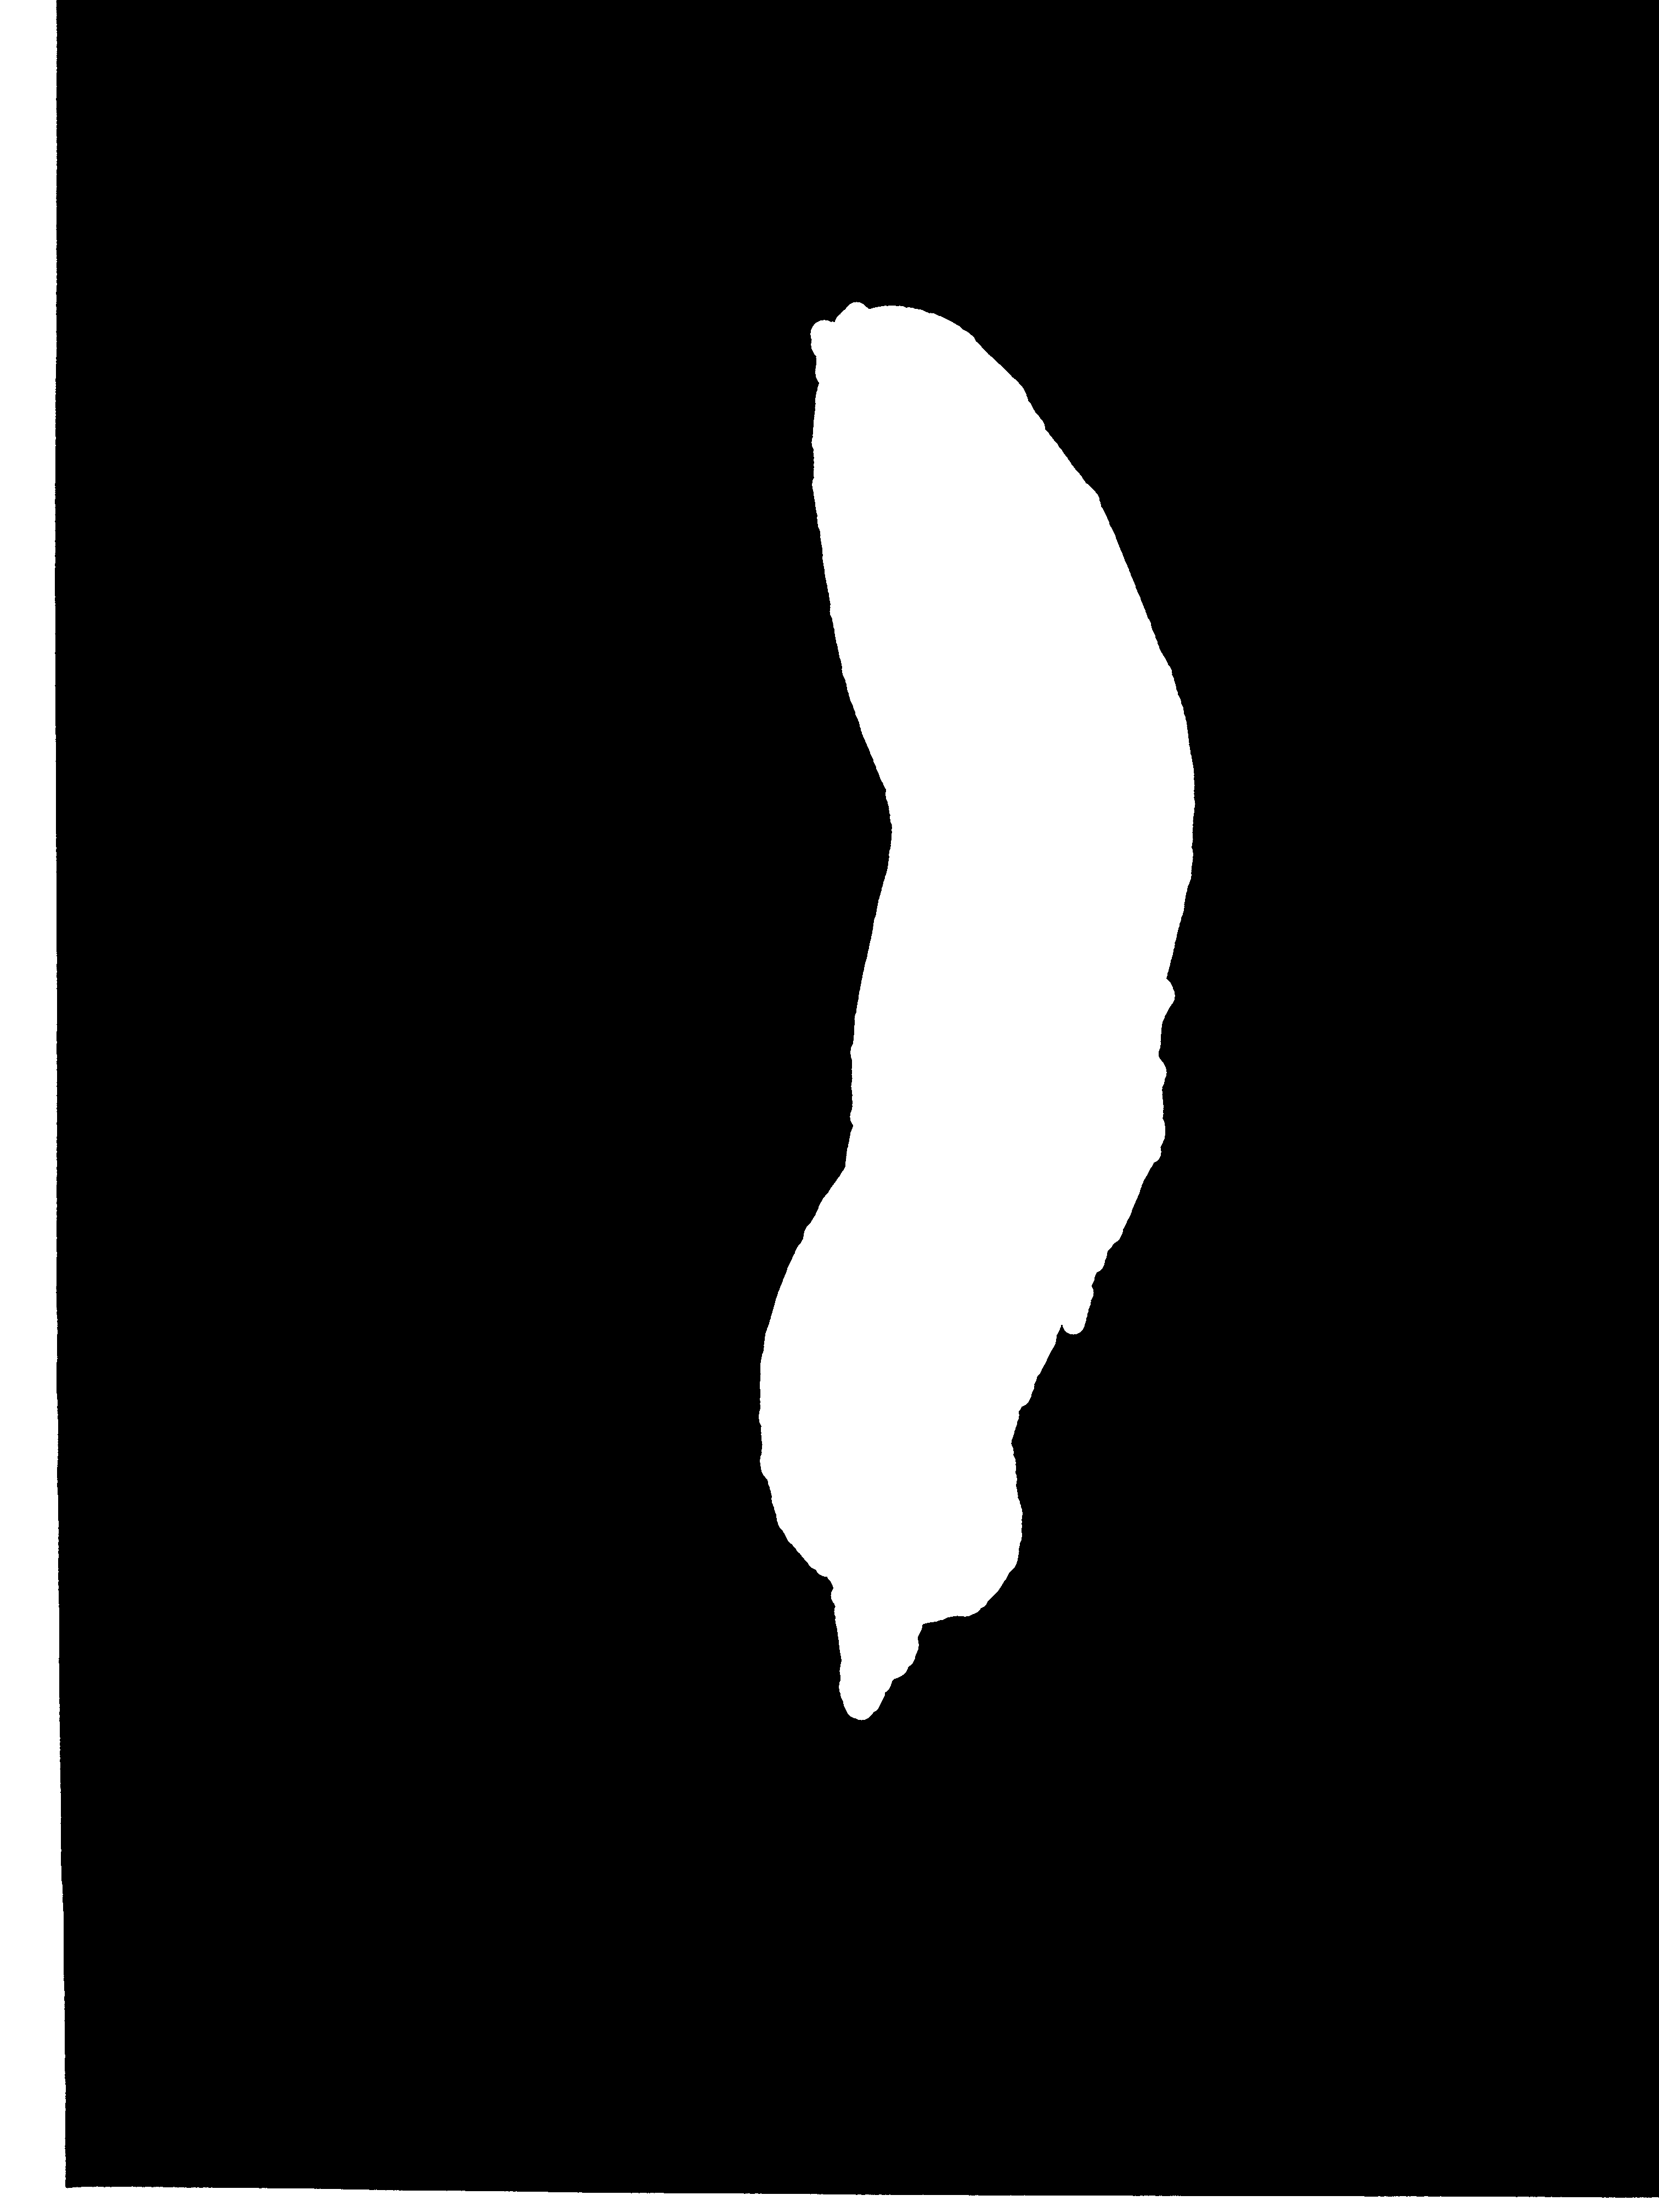

In [363]:
fill_label = label(fillh3)
fig = px.imshow(fillh3, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

In [338]:
props = regionprops_table(fill_label,properties=('minor_axis_length', 'major_axis_length', 'bbox', 'filled_area', 
                                                'bbox_area','perimeter','extent'))
pd.DataFrame(props)

,minor_axis_length,major_axis_length,bbox-0,bbox-1,bbox-2,bbox-3,filled_area,bbox_area,perimeter,extent
0,734.525949,5234.340377,0,0,4032,1250,364888,5040000,10764.657034,0.072398
1,584.174772,4131.762727,80,1174,3804,1950,1459673,2889824,9318.706704,0.505108


In [326]:
#Looks like the twigs and small roots are increasing the overall area
#Get the largest connected component

def getLargestCC(segmentlabel):    
    assert( segmentlabel.max() != 0 ) # assume at least 1 CC
    largestCC = segmentlabel == np.argmax(np.bincount(segmentlabel.flat)[1:])+1
    return largestCC
largest = getLargestCC(fill_label)
larlabel = label(largest)
props = regionprops_table(larlabel,properties=('major_axis_length', 'minor_axis_length', 'bbox', 'filled_area', 
                                                'bbox_area','perimeter','extent'))
pd.DataFrame(props)

,major_axis_length,minor_axis_length,bbox-0,bbox-1,bbox-2,bbox-3,filled_area,bbox_area,perimeter,extent
0,2102.327432,1136.049095,1075,888,3293,2030,1861519,2532956,5746.804758,0.73492


In [327]:
row1 = props['bbox-0'][0]; row2 = props['bbox-2'][0]
col1 = props['bbox-2'][0]; col2 = props['bbox-3'][0]
rows=abs(row1-row2)
cols=abs(col1-col2)
print (rows, cols)


2218 1263
